In [1]:
import os
import numpy as np
from pandas import read_csv
from tqdm import tqdm

## Section 1: Primary Analysis

#### 1.1 Load and prepare data

In [2]:
## Load behavioral correlates.
data = read_csv(os.path.join('data','correlates.csv'))

## Load total scores.
scores = read_csv(os.path.join('data','scores.csv'))

## Load rejection metrics.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Merge DataFrames.
data = data.merge(scores).merge(metrics[['platform','subject','infreq']])

## Re-format infrequency.
data['infreq'] = np.where(data['infreq'] > 0, 0, 1)

#### 1.2 Bootstrap Analysis

In [3]:
from pandas import DataFrame, concat
from scipy.stats import spearmanr

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define variables.
x_var = 'kappa'
y_var = '7d'

## Define bootstrap parameters.
n_total = np.linspace(100,300,9).astype(int)
percentiles = [0.05,0.1,0.15,0.2]
n_bootstrap = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define indices.
pass_ix, = np.where(data.infreq)
fail_ix, = np.where(1-data.infreq)

## Preallocate space.
corr = np.zeros((n_bootstrap, len(n_total), len(percentiles)))
pval = np.zeros_like(corr)

## Main loop.
for k, p in enumerate(percentiles):
    
    for i in tqdm(range(n_bootstrap)):
    
        for j, n in enumerate(n_total):
    
            ## Define fraction of participants to include.
            n_fail = int(p * n)
            n_pass = int(n - n_fail)

            ## Bootstrap participants.
            ix = np.concatenate([
                np.random.choice(pass_ix, n_pass, replace=False),
                np.random.choice(fail_ix, n_fail, replace=False)
            ])

            ## Compute correlation.
            corr[i,j,k], pval[i,j,k] = spearmanr(data.loc[ix,x_var], data.loc[ix,y_var])

## Convert to DataFrame.    
data = []
for i, p in enumerate(percentiles):
    df = DataFrame(corr[...,i], columns=n_total)
    df['percentile'] = p
    data.append(df)

## Melt DataFrame.
data = concat(data).melt(id_vars='percentile', var_name='sample', value_name='spearman')

## Convert to GroupBy table.
gb = data.groupby(['percentile','sample']).quantile([0.025,0.5,0.975]).reset_index()

100%|██████████| 5000/5000 [01:15<00:00, 66.16it/s]


## Section 2: Plotting

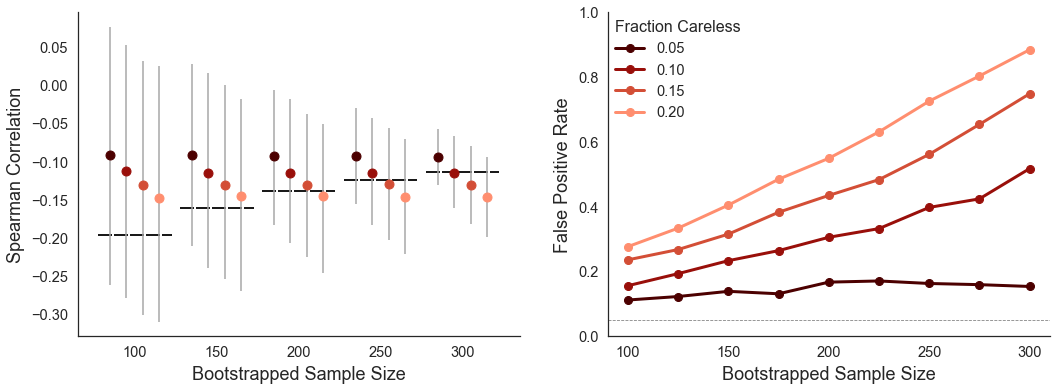

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(15,6))
# palette = sns.color_palette(n_colors=4).as_hex()
palette = ['#4c0000','#990f0a','#d34e36','#ff8e6f']

## Define critical values.
critical_values = 1.96 / np.sqrt(n_total - 1)

## Compute false positive rate.
fpr = (corr.swapaxes(1,2) < -critical_values).mean(axis=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot correlations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively plot correlations.
for i, sample in enumerate([100,150,200,250,300]):

    ## Define centers and tails.
    mu = gb.query(f'sample=={sample} and level_2 == 0.5').spearman.values
    lb = mu - gb.query(f'sample=={sample} and level_2 == 0.025').spearman.values
    ub = gb.query(f'sample=={sample} and level_2 == 0.975').spearman.values - mu
    
    ## Define x-axis.
    X = i + np.array([-0.3,-0.1,0.1,0.3])
    
    ## Plot estimates.
    for x, y, y1, y2, color in zip(X, mu, lb, ub, palette):
        axes[0].errorbar(x, y, fmt='o', yerr=np.stack([[y1,y2]], axis=1), markersize=9,
                         color=color, ecolor='0.65')

## Add critical values.
for i, y in enumerate(critical_values[::2]):
    axes[0].plot([i-0.45,i+0.45], [-y,-y], color='0.1', lw=2, linestyle=(0, (7, 1)), zorder=-1)

## Add detail.
# axes[0].legend_.set_visible(False)
axes[0].set(xticks=np.arange(5), xticklabels=[100,150,200,250,300])
axes[0].set_xlabel('Bootstrapped Sample Size', fontsize=18, labelpad=6)
axes[0].set_ylabel('Spearman Correlation', fontsize=18, labelpad=6)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot false positive rates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Plot false positive rates.
for y, label, color in zip(fpr, percentiles, palette): 
    axes[1].plot(n_total, y, 'o-', lw=3, color=color, label='%0.2f' %label, markersize=8)
axes[1].axhline(0.05, color='0.5', lw=0.8, linestyle='--', zorder=-1)

## Add detail.
axes[1].set(xticks=[100,150,200,250,300], ylim=(0,1))
axes[1].set_xlabel('Bootstrapped Sample Size', fontsize=18, labelpad=6)
axes[1].set_ylabel('False Positive Rate', fontsize=18, labelpad=6)
leg = axes[1].legend(loc=2, frameon=False, borderpad=0, title='Fraction Careless')
leg._legend_box.align = "left"

sns.despine()
plt.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.15, wspace=0.2)
plt.savefig(os.path.join('..','figures','main_03b.png'), dpi=180, transparent=True)